# <i class="fas fa-circle" style="color: #d9534f;"></i> Gaze estimation
<span style="background-color: #d9534f; color: white; border-radius: 10px; padding-top: 2px; padding-bottom: 2px; padding-left: 6px;padding-right: 6px;">mandatory</span> <span style="background-color: #343A40; color: white; border-radius: 10px; padding-top: 2px; padding-bottom: 2px; padding-left: 6px;padding-right: 6px;">notebook</span>
This is the first mandatory exercise which means you will have to hand in this Jupyter Notebook with your implementation and notes. This exercise is split into multiple parts which have to be submitted together. The submission deadline is available on LearnIT.

## Tasks
The following list is a summary of the tasks you need to complete to pass the exercise. Find the tasks in the exercise text with further instructions on what to do. 

<i class="fas fa-exclamation-circle" style="color: #d9534f;"></i> {ref}`gaze:viz` (**A-B**)

<i class="fas fa-exclamation-circle" style="color: #d9534f;"></i> {ref}`gaze:implement` (**A-D**)

<i class="fas fa-exclamation-circle" style="color: #d9534f;"></i> {ref}`gaze:evaluation` (**A-D**)

<i class="fas fa-exclamation-circle" style="color: #d9534f;"></i> {ref}`gaze:improve` (**A-C**)



## Overview

In this exercise you will implement a regression model to estimate where a person is looking (this is known as *gaze*). Gaze estimation is performed by capturing images of a users eye as shown in FIG and mapping them to screen positions. Humans look at things by orienting their eyes so that the point of focus is directly in line with a point on their retinas known as the *fovea* (shown in {numref}`fig-model`). Therefore, the pupil position can be used to infer gaze. 

```{note}
The *fovea* is located slightly differently from person to person ($\pm$ 5 degrees) and as a consequence, a gaze model has to be retrained for every person using it. This difference is shown in {numref}`fig-kappa`.
```


```{figure} ../img/model.png
---
name: fig-model
width: 350px
---
Diagram of a gaze estimation system. The eye, which is directed
at a specific point on the screen is captured by the camera. The two red lines represent an unknown transformation from image to eye and eye to screen. We learn this transformation directly which is shown as $f_{\theta}(x, y)$ in the diagram.
```

In this exercise, $f_{\theta}(x, y)$ is the model mapping pupil positions in images (the $x$ and $y$ parameters) onto screen coordinates (the output of $f_{\theta}$). The model is trained using a set of paired pupil and screen positions. This ground-truth dataset has been collected in advance by asking the participant to look at a specific point on a screen while capturing an eye image. We have detected the pupils for each image using ellipse approximation. 

The next section will introduce you to the dataset.

```{figure} ../img/kappa.jpg
---
name: fig-kappa
figclass: margin
---
Shows the distinction between the visual and optical axes. The optical axis is defined as an axis perpendicular to the lens behind the pupil. The visual axis is personally dependent and is determined by the placement of the *fovea*.
```


### About data

The goal of this exercise is to estimate the gaze of image sequences using a regression model. Each image sequence contains 9 images for calibration and a varying number of images for inference. The calibration samples always represent the same 9 screen positions which form a simple 3 by 3 grid. An example of calibration images are shown in
{numref}`fig-calibration`. For each sequence, you will use the 9
calibration samples to train a regression model and then use the model
to predict gaze positions for the rest of the images.

```{figure} ../img/calibration.jpg
---
name: fig-calibration
width: 60%
---
Calibration images. All image sequences contain 9 calibration images
which all have equivalent gaze positions.
```

`positions.json` contains the ground-truth gaze positions for each image as an array
(stored as $y, x$ for each point). The included image sequences (found
in `inputs/images`) are divided into two groups:

- **No head movement:** `pattern0`, `pattern1`, `pattern2`, `pattern3`

- **Head movement and rotation:** `movement_medium`, `movement_hard`,

You may want to focus on the ones without head movement for now.

In [2]:
import os
import sys
import json
import cv2 as cv
import numpy as np
import pandas as pd

from dataclasses import dataclass
from typing import Tuple, NamedTuple, List

import matplotlib.pyplot as plt
import seaborn as sns

from ipywidgets import interact

```{note}
The real notebook (the one in the materials repository or the one you can download from this page) contains some extra utility code that has been hidden here for brevity. The code is fully commented and we recommend you read it whenever you are in doubt about what is happening.
```

In [3]:
def load_json(folder, filename):
    """Load json file from subdirectory in "inputs/images" with the given filename
    - without .json extension!

    Returns: The json data as a dictionary or array (depending on the file).
    """
    with open(os.path.join(os.path.abspath('../inputs/images/' + folder), f'{filename}.json')) as file:
        data = json.load(file)
        return data

def create_pupil_dataframe(data):
    df = pd.DataFrame(data)
    df.index.name = 'idx'
    return df

def create_glint_dataframe(data):
    rows = [[{'idx': idx, 'num': idx2, 'x': x, 'y': y} for idx2, (x, y) in enumerate(row)] for idx, row in enumerate(data)]
    rows = np.concatenate(rows)
    df = pd.DataFrame.from_records(rows)
    return df

def create_pos_dataframe(data):
    rows = [{'idx': idx, 'x': x, 'y': y} for idx, (x, y) in enumerate(data)]
    df = pd.DataFrame.from_records(rows, index='idx')
    return df

def dist(a, b):
    return np.linalg.norm(a - b)

def center_crop(img, size):
    width, height = size
    i_height, i_width = img.shape[:2]

    dy = (i_height-height)//2
    dx = (i_width-width)//2

    return img[dy: i_height-dy, dx: i_width-dx]

In [4]:
def open_img(path, idx):
    """Open a single image from the provided path. The index specifies the image name."""
    img = cv.imread(path + f'/{idx}.jpg')
    if img is None:
        raise IOError("Could not read image")
    return img

def draw_features(img, feature):
    """Helper for drawing pupil and glints onto an image."""
    frame = img.copy()
    feature.pupil.draw(frame, color=(0, 0, 255), thickness=5)
    feature.glints.draw(frame, color=(0, 255, 0), thickness=3, size=20)
    return frame

def load_dataset(folder):
    """Load all images and screen positions for a valid data folder (any folder in "inputs/images")."""
    path = os.path.abspath('../inputs/images/' + folder)

    positions = np.array(load_json(path, 'positions'))
    images = [open_img(path, i) for i in range(len(positions)-1)]

    return list(map(lambda x: Sample(*x), zip(images, positions)))

def predict_features(dataset):
    """Predict eye image features for all images in `dataset`. The dataset is a list of Sample instances."""
    res = []
    for sample in dataset:
        pupil = find_pupil(sample.image)
        glints = find_glints(sample.image, pupil.center)
        res.append(FeatureDescriptor(pupil, glints))
    return res

def show_example_features(images, pupils):
    """Draw a grid of images with the predicted pupils drawn on top."""
    n = len(images)
    cols = 8
    rows = n//8+1

    fig, ax = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    for i, d in enumerate(images):
        img = d.copy()
        row = pupils.iloc[i]
        img = cv.ellipse(img, (int(row['cx']), int(row['cy'])), (int(row['ax']/2), int(row['ay']/2)), row['angle'], 0, 360, (255, 0, 0), 5)
        ax[i//cols, i%cols].imshow(center_crop(img, (250, 250)))
    for row in ax:
        for a in row:
            a.get_xaxis().set_visible(False)
            a.get_yaxis().set_visible(False)
    plt.show()

(gaze:viz)=
## <i class="fas fa-exclamation-circle mandatory"></i> Data and visualization
First you will familiarise yourself with the problem domain and data sources by doing a number of visualisations. 

The code below loads all the datasets specified in `inputs` and predicts features for each image. The `show_example_features` function then plots a grid of all the images from one of the datasets. 

**A): <i class="fas fa-code"></i>** Test the visualisation for different datasets (by changing the array index when accessing images, positions, or pupils).

In [5]:
# Enter dataset folder name here (any subfolder in inputs/images will do)
dataset_folders = ['pattern0', 'pattern1', 'pattern2', 'moving_medium', 'moving_hard']

# Load detected pupil features
pupils = [create_pupil_dataframe(load_json(f, 'pupils')) for f in dataset_folders]
# Load screen gaze positions
positions = [create_pos_dataframe(load_json(f, 'positions')) for f in dataset_folders]
# Load eye images
images = [[open_img(os.path.abspath('../inputs/images/' + f), i) for i in range(len(p)-1)] for p, f in zip(positions, dataset_folders)]

In [6]:
# Create train and test splits
pupils_train = [df.iloc[:9] for df in pupils]
pupils_test = [df.iloc[9:] for df in pupils]
positions_train = [df.iloc[:9] for df in positions]
positions_test = [df.iloc[9:] for df in positions]
images_train = [li[:9] for li in images]
images_test = [li[9:] for li in images]

```{admonition} Details about the data format
:class: tip, dropdown
The dataframes each contain a number of columns. Here's a description of what data each column contains.

**Pupil dataframes:**
| Name | Meaning |
| ---- | ------- |
| `cx` | Center $x$-coordinate |
| `cy` | Center $y$-coordinate |
| `ax` | Radius 1 |
| `ay` | Radius 2 |
| `angle` | Angle |

**Position dataframes**
| Name | Meaning |
| ---- | ------- |
| `x` | $x$-coordinate |
| `y` | $y$-coordinate |
```

0


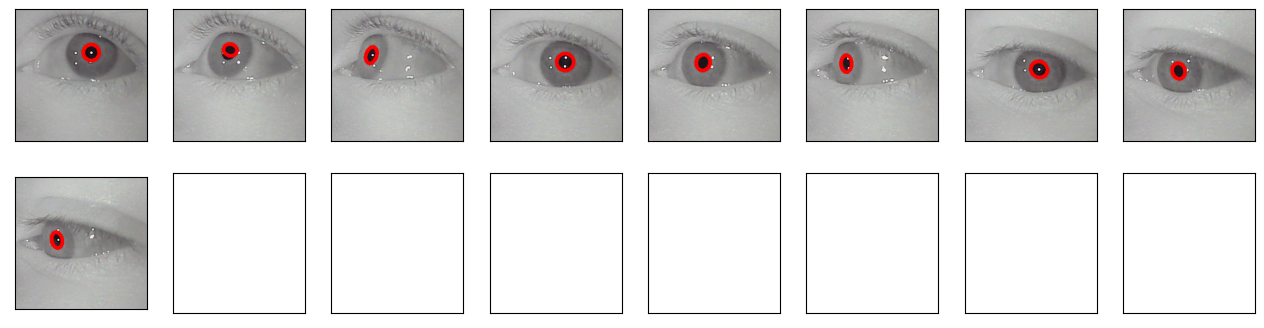

1


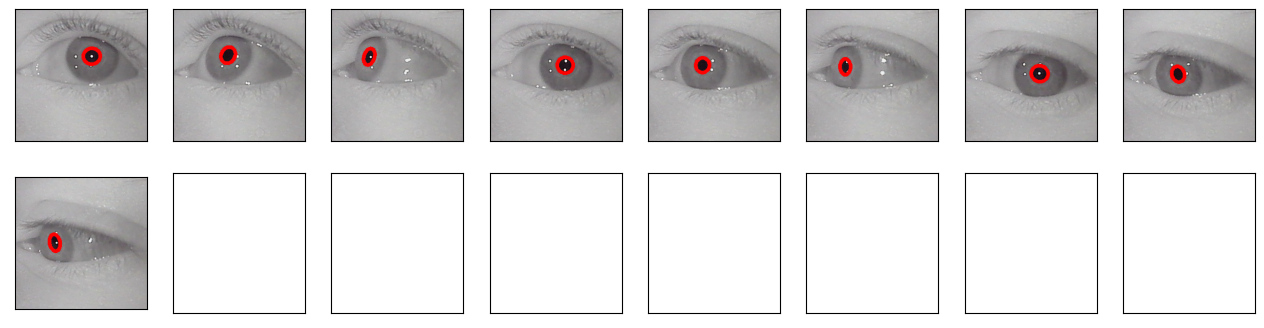

2


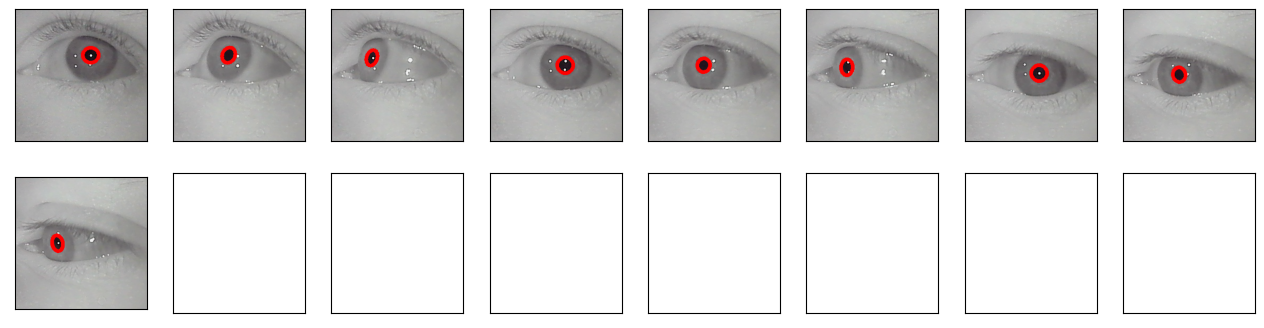

3


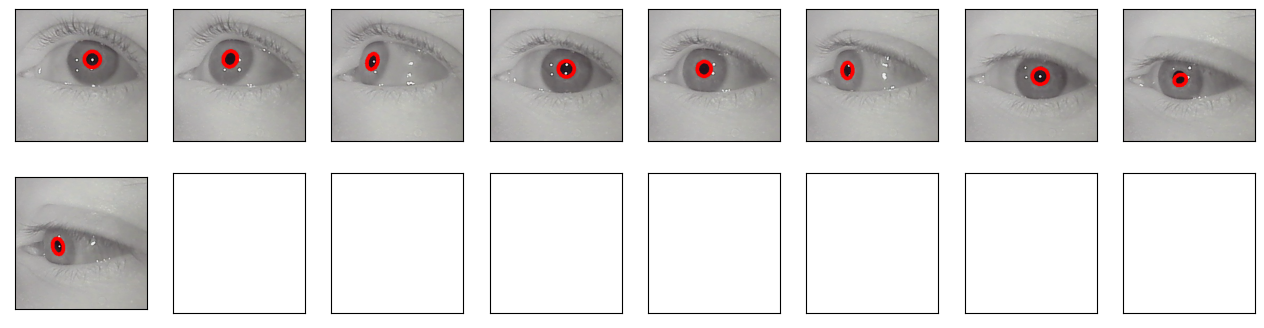

4


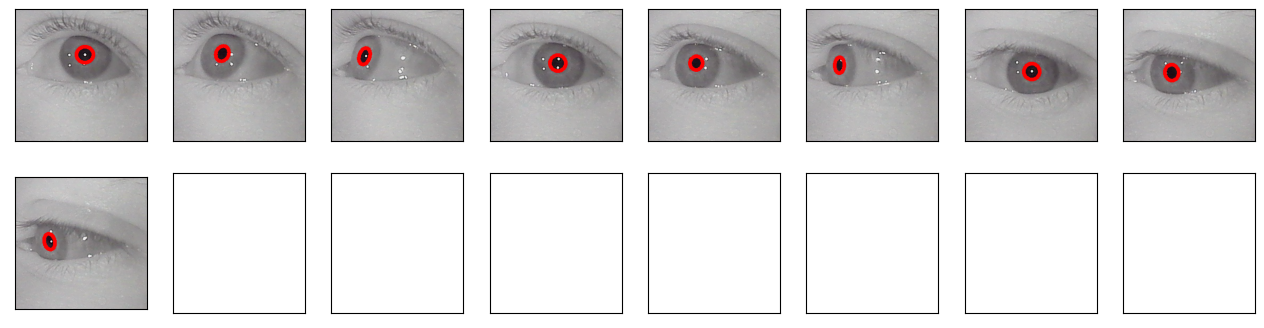

In [7]:
#show_example_features(images_train[3], pupils_train[3])
for i in range(len(images_train)):
    print(i)
    show_example_features(images_train[i], pupils_train[i])

Lets visualize the recorded screen gaze positions. The subject was instructed to look at a red dot on a specific point on a screen while the camera captured each image. We provide the visualisation code for this part:

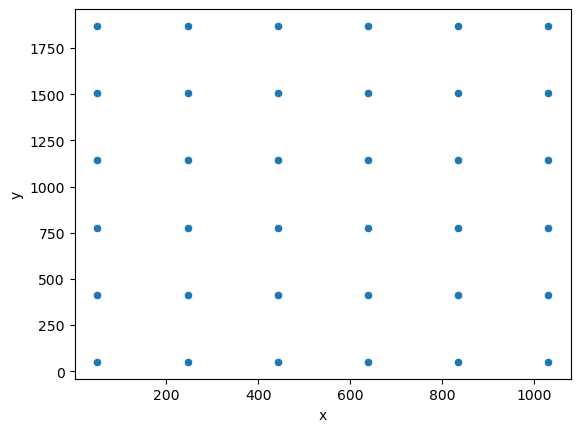

In [8]:
sns.scatterplot(x='x', y='y', data=positions_test[0]);

**B): <i class="fas fa-code"></i>** Test the visualisation for different datasets (by changing the array index when accessing images, positions, or pupils). Do the same but for the detected pupil positions. We provide the `DataFrame` object for each so you should be able to simply modify the example above.

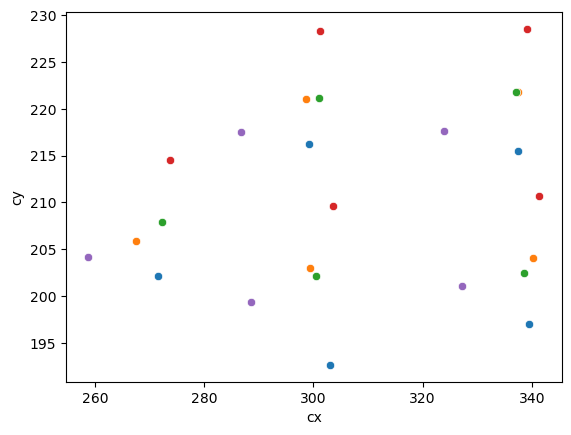

In [9]:
pupils[0].head()

# Write the plotting code here (using Seaborn is easier, but feel free to use Matplotlib as well)
for i in range(len(pupils[i].head())):
    sns.scatterplot(x='cx', y='cy', data=pupils[i].head());


(gaze:implement)=
## <i class="fas fa-exclamation-circle mandatory"></i> Implement a gaze estimation model

```{figure} ../img/gaze2.jpg
---
name: fig-gaze
figclass: margin
---
Calibration images. All image sequences contain 9 calibration images
which all have equivalent gaze
positions.
```

The mapping function $f_\theta(x, y)$ as shown in
{doc}`../main` is unknown. Because the pupil moves in a spherical curve (this is only true when the head is fixed), the relationship between pupil position in the image and gaze is non-linear. In this exercise, however, you will approximate the gaze mapping by a linear function. Because the function has two outputs, it is easier to train one model for each coordinate. You do this as in the exercises but with one model for the $x$ coordinate and one for the $y$
coordinate. To get the screen coordinates $x'$, $y'$ we have

$$
\begin{aligned}
x' &= ax + by + c\\
y' &= dx + ey + f
 \end{aligned}
$$

**A): <i class="fas fa-pen"></i>** **Construct the design matrix:** Write design matrices for both equations above. Use the previous exercises as a guideline. Answer the following:
- What are the knowns and unknowns in the equations?
- How many parameters does the model have?
- How many points (pupil to gaze point correspondances) do we need to solve the equations?
- What effect does the number of points used have on the solution?

The principle is demonstrated in {numref}`fig-gaze` to the right. Here, the $x$ coordinate of the pupil maps to the $x$ coordinate on the screen. In the real model, we use both $x$ and $y$ as inputs to both the model estimating the $x$ position on the screen and the model estimating the $y$ position.

**B): <i class="fas fa-code"></i>** **Implement the design matrix:** Implement a function for generating a design matrix from pupil positions.

**C): <i class="fas fa-code"></i>** **Calibration:** Learn the parameters $\theta$ for the linear regression using the `pupils_train` and `positions_train` lists (remember to select one of the datasets in the lists). Create a design matrix from the pupil positions. Use *two* linear models, as described above, one to learn the X-coordinates and one to learn the Y-coordinates. 

```{note}
This is possibly the most difficult part of the exercise. Try to use what you learned in the two non-mandatory exercises and apply it here. Remember that you need to fit two separate models, one for each screen coordinate.
```

**D): <i class="fas fa-code"></i>** **Estimation:** Implement a function which predicts the gaze point given a pupil position using the learned models. For reference, the linear model has the form $f(x; \theta)=\theta_0 x_0 + \theta_1 x_1 + \theta_2$. You may calculate the point for each coordinate seperately. Then calculate and return the estimated screen coordinates using the models created during calibration.

In [10]:
# You may use this cell for your implementation.

# A) ---------------------------------
# x' = [[x, y, 1]] [[a], [b], [c]]
# y' = [[x, y, 1]] [[d], [e], [f]]
# We already know the positions of the points (x, y), and the values a, b, c and d, e, f are the unknowns in the respective equations.
# In both cases the model has 3 parameters ((a, b, c) and (d, e, f))
# We need at least the same amount of equations as there are unknowns in the equations. Therefore, we need at least 3 points to solve the equations
# I believe the number of points used affects the 'stability' of the solution.
# Having more points reduces the impact outliers would have on the solution and vice versa.

# B) ---------------------------------
def get_design_matrix(x, order):
    if order == 1:
        matrix = np.array([x.cx[0], x.cy[0], 1])
        for i in range(1, len(x.cx)):
            matrix = np.vstack((matrix, np.array([x.cx[i], x.cy[i], 1])))
    elif order == 2:
        matrix = np.array([(x.cx[0]*x.cx[0]), (x.cy[0]*x.cy[0]), (x.cx[0]*x.cy[0]), x.cx[0], x.cy[0], 1])
        for i in range(1, len(x.cx)):
            matrix = np.vstack((matrix, np.array([(x.cx[i]*x.cx[i]), (x.cy[i]*x.cy[i]), (x.cx[i]*x.cy[i]), x.cx[i], x.cy[i], 1])))

    return matrix

# C) ---------------------------------
# Estimates parameters theta
def estimate(X, y, order):
    dm = get_design_matrix(X, order)
    params = np.linalg.lstsq(dm, y)

    return params

# D) ---------------------------------
# Evaluates the model
def get_model(X, params, axis, order):
    if order == 1:
        y = X[0]*params[0][0][axis] + X[1]*params[0][1][axis] + params[0][2][axis]
    elif order == 2:
        y = (X[0]*X[0])*params[0][0][axis] + (X[1]*X[1])*params[0][1][axis] + (X[0]*X[1])*params[0][2][axis] + X[0]*params[0][3][axis] + X[1]*params[0][4][axis] + params[0][5][axis]
    return y



(gaze:evaluation)=
## <i class="fas fa-exclamation-circle mandatory"></i> Evaluation of the regression model

C:\Users\mikke\AppData\Local\Temp\ipykernel_20928\2993804888.py:29: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params = np.linalg.lstsq(dm, y)


Set  0 
MSE: x, y
123196.05109688854 
 156529.926938352
RMSE: x, y
350.99295020967094 
 395.63863175674845 

Set  1 
MSE: x, y
143434.0239637734 
 174418.79303527076
RMSE: x, y
378.72684610913626 
 417.6347603292508 

Set  2 
MSE: x, y
164452.8995750334 
 210973.8405029683
RMSE: x, y
405.5279269976772 
 459.3188875965894 

Set  3 
MSE: x, y
144849.60484829883 
 126786.20482435907
RMSE: x, y
380.59112555115996 
 356.0705054120027 

Set  4 
MSE: x, y
328624.6217341596 
 322421.0238371977
RMSE: x, y
573.2579015889442 
 567.8212956883509 

Set  0
Euclidian Distances:
[ 301.53051337  332.05748941  750.43590056 1124.81404376 1443.28108749
 1715.59554792  157.91330115  299.10043789  765.84123217 1165.92044977
 1532.28722488 1786.05295784  164.67803881  337.71574092  778.28373622
 1158.99531954 1521.96250443 1767.84552874  337.370623    428.19677824
  826.54665092 1200.25807481 1520.08153769 1780.68145002  436.02141093
  562.95598843  893.69919175 1248.46017926 1551.39780685 1789.2192355
  576

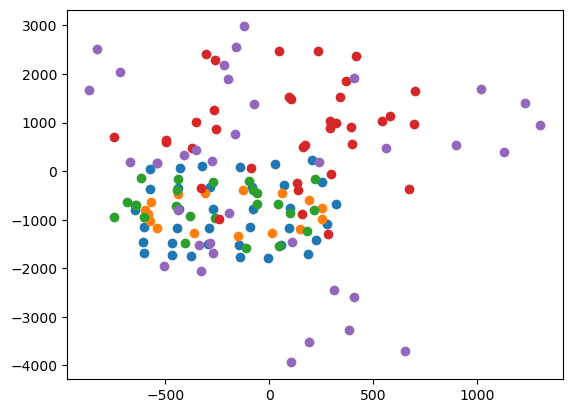

In [11]:
# Get true x and y coordinates as an np.array for a given set (0-4)
def trueValuesToArray(set):
    pupilTestXY = np.array([pupils_test[set].cx.values[0], pupils_test[set].cy.values[0]])
    for i in range(1, len(pupils_test[set].cx.values)):
       pupilTestXY = np.vstack((pupilTestXY, np.array([pupils_test[set].cx.values[i], pupils_test[set].cy.values[i]])))
    pupilTestXY = np.transpose(pupilTestXY)
    
    return pupilTestXY

# Calculate predicted x and y coordinates as two seperate np.arrays for a given set (0-4)
def calculatePredictions(set, order):
    pupilTestXY = trueValuesToArray(set)

    predictedXs = get_model(pupilTestXY, estimate(pupils_train[set], positions_train[set], order), 0, order)
    predictedYs = get_model(pupilTestXY, estimate(pupils_train[set], positions_train[set], order), 1, order)
    
    return (predictedXs, predictedYs)

# A) ---------------------------------
# Calculate RMSE (or MSE if not specified)
def rmse(X, y, squareRoot):
    #X = normalized(X)
    sum = 0
    for i in range(0, len(X)):
        sum += np.power(X[i] - y[i], 2)
    mse = (1/len(X)) * sum

    if squareRoot:
        return np.sqrt(mse)
    else:
        return mse

# Calculating MSE and RMSE for x and y coordinates for every test data set
for case in range(0, len(pupils_test)):
    xs, ys = calculatePredictions(case, 1)
    trueValues = trueValuesToArray(case)
    mseX = rmse(xs, trueValues[0], False)
    mseY = rmse(xs, trueValues[1], False)
    rmseX = np.sqrt(mseX)
    rmseY = np.sqrt(mseY)
    print("Set ", case, "\nMSE: x, y")
    print(mseX, "\n", mseY)
    print("RMSE: x, y")
    print(rmseX, "\n", rmseY, "\n")

    

# B) ---------------------------------
# Running this whole section will print out the requested values to be calculated in 5.3.5 B)
def calculateMean(edSet):
    sum = 0
    for i in range(0, len(edSet)):
        sum += edSet[i]
    mean = sum / len(edSet)
    return mean

def calculateVariance(edSet):
    mean = calculateMean(edSet)
    sum = 0
    for i in range(0, len(edSet)):
        sum += np.power(edSet[i] - mean, 2)
    variance = sum / len(edSet)
    return variance

euclidianDistances = np.array([])
for case in range(0, len(pupils_test)):
    print("Set ", case)
    xs, ys = calculatePredictions(case, 1)
    trueValues = trueValuesToArray(case)

    # Calculating euclidian distance between each point
    for i in range(0, len(xs)):
        ed = np.sqrt(np.power(trueValues[0][i] - xs[i], 2) + np.power(trueValues[1][i] - ys[i], 2))
        euclidianDistances = np.append(euclidianDistances, np.array([ed]))
    print("Euclidian Distances:")
    print(euclidianDistances)

    # Calculating mean
    mean = calculateMean(euclidianDistances)
    print("Mean: ")
    print(mean)

    # Calculating variance
    variance = calculateVariance(euclidianDistances)
    print("Variance: ")
    print(variance)
    
    print("\n")
    euclidianDistances = np.array([])
        
def getErrors(set, order):
    xs, ys = calculatePredictions(set, order)
    trueValues = trueValuesToArray(set)

    allXErrors = np.array([])
    allYErrors = np.array([])
    for i in range(0, len(xs)):
        xError = trueValues[0][i] - xs[i]
        yError = trueValues[1][i] - ys[i]
        allXErrors = np.append(allXErrors, xError)
        allYErrors = np.append(allYErrors, yError)
    
    return (allXErrors, allYErrors)

# Calculate distance error seperately and correlation for each dataset
def calculateCorrelations(order):
    correlations = np.array([])
    for case in range(0, len(pupils_test)):
        # Seperate distance errors (and covariance)
        allXErrors, allYErrors = getErrors(case, order)

        Xmean = calculateMean(allXErrors)
        Ymean = calculateMean(allYErrors)

        sum = 0
        for i in range(0, len(allXErrors)):
            sum += (allXErrors[i] - Xmean) * (allYErrors[i] - Ymean)

        cov = (1 / len(allXErrors)) * sum
        cor = cov / (np.sqrt(calculateVariance(allXErrors)) * np.sqrt(calculateVariance(allYErrors)))

        correlations = np.append(correlations, cor)

    return correlations

print("Correlations:\n", calculateCorrelations(1))


# The correlation for the distance errors of the coordinates tells us how correlated the x and y values are to each other.
# I guess because most of the correlation values lie close to 0, this tells us that the correlation between x and y is quite small.
# They don't follow a trend.

# Plotting errors for each set
for case in range(0, len(pupils_test)):
    xErrors, yErrors = getErrors(case, 1)
    plt.scatter(xErrors, yErrors)

# The distance metric is useful for this model, as the distance between coordinates can tell us how well the model performed.
# Larger distances would mean the results were not very similar to the expected, while smaller distances would mean similar results
# with very little error between the coordinates.

C:\Users\mikke\AppData\Local\Temp\ipykernel_20928\2993804888.py:29: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params = np.linalg.lstsq(dm, y)


Text(0, 0.5, 'y')

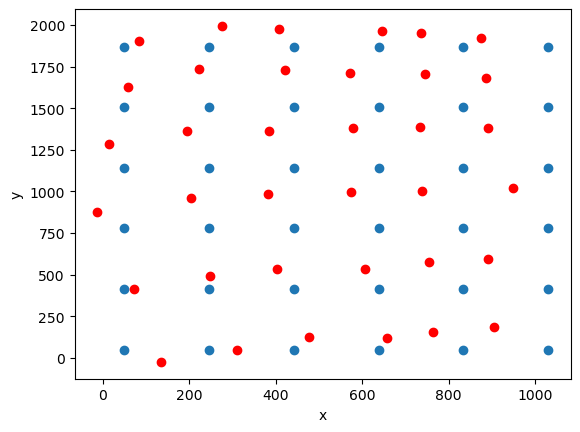

In [12]:
# C) ---------------------------------
# Seeing as the correlation values for the x and y errors all lie close to 0, it can be said that the correlation is small.
# Additionally, as seen in the visualised graph of the errors, the errors for some particular sets are very spread out.
# Of course they are closer for some sets (the green one, set 2), which would mean the correlation and therefore the consistency of the results are higher.
# But overall both the visualisation and the correlation values tells us, that the model did not manage to result errors
# that were highly correlated, meaning it was not able to perform consistently.
# Not only were there errors, but they were also inconsistent.

# Using the same corresponding points for both training and testing should result in no errors.
# The correlation would therefore be as high as it could get, and the visualisation would just be 1 plotted point


# D) ---------------------------------
# Visualising predicted values and true values
predictedXs, predictedYs = calculatePredictions(0, 1)

plt.scatter(positions_test[0].x, positions_test[0].y)

plt.scatter(predictedXs, predictedYs, color='r')
plt.xlabel('x')
plt.ylabel('y')

# It can be seen in the visualisation that the linear model is quite erronous in its predictions.
# Of course it is not completely off and totally hopeless - the predictions are still within the general range of the actual points.
# However, as the errors are not consistent either, it does show that the linear model is not be the most suitable model for the problem.
# In terms of the quality of the pupil input points, overall they seemed to be good.
# I only noticed small problems in set 0 and 3 (as seen in the pupil pictures with red rings drawn around the pupil)
# Having less accurate input points would of course result in a wrong matching between the input and output of the "ground truth" results.
# The final errors would be affected by this, as if the true results were not consistent, the predicted results would certainly not be either.


**A): <i class="fas fa-code"></i>** **Calculate errors:** For each dataset, predict gaze positions and calculate the *mean squarred error* between the true values in `positions_test` and the predictions (one MSE for each coordinate). Additionally:
- Calculate the square root of the *mse* for each dataset.

**B): <i class="fas fa-code"></i>** **Calculate distance errors:**
- Calculate the euclidean distance between each predicted point and ground truth screen position. 
- Calculate the mean and variance of the distance error for each dataset. 
- Calculate the distance error for $x$ and $y$ seperately (this is just the absolute value of the error). Then calculate the correlation for the $x$ and $y$ errors for each dataset.
- <i class="fas fa-pen"></i> What does the correlation tell you of the error for each coordinate?
- Visualise the results using a suitable choice of plots (only include plots you think show something valuable about the results).
- <i class="fas fa-pen"></i> Explain why the distance metric is useful for this particular model.

**C): <i class="fas fa-pen"></i>** **Evaluate:**
- How does the model perform? Use both metrics and your visualisations to evaluate the performance.
- Explain your results in the notebook. Don't just save them in variables. 
- Explain any significant differences between the results for each dataset? 
- What would happen if you used the same corresponding points (i.e. dataset) for both training and testing?

**D): <i class="fas fa-code"></i>** **Create visualizations:** Create scatterplots similar to the ones shown earlier in the exercise, but with both ground truth `positions` and predictions. Answer the following:
- <i class="fas fa-pen"></i> Is the linear model a suitable model for this problem? Why/why not? 
- <i class="fas fa-pen"></i> What is the quality of the pupil input points? Are they accurate? What effect does their accuracy have on the final error?


(gaze:improve)=
## <i class="fas fa-exclamation-circle mandatory"></i> Improve the model
Hopefully, you have observed by now that the linear model is not entirely adequate to capture the movement of the pupil. You should understand why this is the case.

This final part of the exercise requires you to modify your linear model into a quadratic model. You have tried this before in one dimension, but here we have two. As before, you will still create one model for each output dimension.

```{note}
It is perfectly possible to create a single model that captures all inputs and outputs. However, we leave it as an optional extra exercise for you to figure out how to do this. Hint: You have to combine the design and parameter matrices in some way for this to work.
```

Since the model is two-dimensional, the quadratic polynomial has a few more factors than for one dimension. The equation for each axis is:

$$
f(x, y) = a\cdot x^2 + b\cdot y^2 + c\cdot xy + d\cdot x + e\cdot y + f.
$$

The design matrices then have the following form:

$$
D_x = D_y = \begin{bmatrix}
 		x_1^2 & y_1^2 & x_1y_1 & x_1 & y_1 & 1\\
  		x_2^2 & y_2^2 & x_2y_2 & x_2 & y_2 & 1\\
  		\vdots &&&&& \\
   		x_2^2 & y_2^2 & x_ny_n & x_n & y_n & 1\\
 	\end{bmatrix}.
$$(dmat)


**A): <i class="fas fa-code"></i>** **Implement model:** Create a new calibration and prediction method that uses quadratic models.

**B): <i class="fas fa-code"></i>** **Evaluate:** Calculate the *rmse* and distance errors as before and compare the two. Visualise errors like you did for the linear model.

**C):** **Compare with linear results:**
- {{ task-impl }} Repeat the evaluation steps for the linear model, i.e. calculate the same metrics and plots. Try to combine the plots for both models to make comparisons easier.
- <i class="fas fa-pen"></i> Use distance means and variance to compare the performance of the linear and quadratic models.
- <i class="fas fa-pen"></i> Which model is best in certain situations and why? Relate this to your knowledge of the problem domain (gaze estimation) and the general problem of choosing model complexity.

In [13]:
# A) ---------------------------------
# I simply modified all the functions used in calculatePredictions() to include an 'order' parameter.
# So in this case, I would give it '2' as the parameter, representing a quadratic function.


C:\Users\mikke\AppData\Local\Temp\ipykernel_20928\2993804888.py:29: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params = np.linalg.lstsq(dm, y)


Set  0 
MSE: x, y
115341.90485490339 
 146743.7200563223
RMSE: x, y
339.6202362270296 
 383.07142944406894 

Set  1 
MSE: x, y
146576.11016438852 
 180037.44900695622
RMSE: x, y
382.8525958699882 
 424.30820049458885 

Set  2 
MSE: x, y
172848.16962535807 
 220946.81142192413
RMSE: x, y
415.7501288338442 
 470.0497967470299 

Set  3 
MSE: x, y
176703.98867117742 
 133502.37611255684
RMSE: x, y
420.36173549834126 
 365.3797697089384 

Set  4 
MSE: x, y
440936.4460466557 
 379915.62030274456
RMSE: x, y
664.0304556619792 
 616.3729555250981 

Set  0
Euclidian Distances:
[ 276.14202311  298.95087676  664.86144323 1045.84223896 1407.28319817
 1743.62895672  154.55567529  236.08208116  662.61006889 1082.95532798
 1511.54140026 1834.21703852  135.83689546  246.39436902  662.55282785
 1067.85402085 1496.32133385 1810.62197285  304.54530589  349.79943922
  715.34129239 1117.60843316 1497.50340442 1836.64297763  416.67330497
  511.54369753  809.27082126 1188.79912397 1551.56988076 1856.32645518


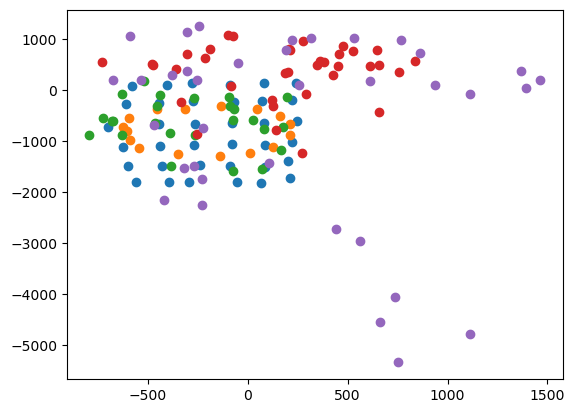

In [14]:
# B) ---------------------------------
# Calculating MSE and RMSE for x and y coordinates for every test data set
for case in range(0, len(pupils_test)):
    xs, ys = calculatePredictions(case, 2)
    trueValues = trueValuesToArray(case)
    mseX = rmse(xs, trueValues[0], False)
    mseY = rmse(xs, trueValues[1], False)
    rmseX = np.sqrt(mseX)
    rmseY = np.sqrt(mseY)
    print("Set ", case, "\nMSE: x, y")
    print(mseX, "\n", mseY)
    print("RMSE: x, y")
    print(rmseX, "\n", rmseY, "\n")

euclidianDistances = np.array([])
for case in range(0, len(pupils_test)):
    print("Set ", case)
    xs, ys = calculatePredictions(case, 2)
    trueValues = trueValuesToArray(case)

    # Calculating euclidian distance between each point
    for i in range(0, len(xs)):
        ed = np.sqrt(np.power(trueValues[0][i] - xs[i], 2) + np.power(trueValues[1][i] - ys[i], 2))
        euclidianDistances = np.append(euclidianDistances, np.array([ed]))
    print("Euclidian Distances:")
    print(euclidianDistances)

    # Calculating mean
    mean = calculateMean(euclidianDistances)
    print("Mean: ")
    print(mean)

    # Calculating variance
    variance = calculateVariance(euclidianDistances)
    print("Variance: ")
    print(variance)
    
    print("\n")
    euclidianDistances = np.array([])

# Correlations
print("Correlations:\n", calculateCorrelations(2))

# Plotting errors for set 0, comparing the linear and quadratic
for case in range(0, len(pupils_test)):
    xErrors, yErrors = getErrors(case, 2)
    plt.scatter(xErrors, yErrors)



# With this, it can be seen that the different values compare as follows:
# Linear: (first 3 sets)
# RMSE: ((350.99295020967094, 395.63863175674845), (378.72684610913626, 417.6347603292508), (405.5279269976772, 459.3188875965894))
# Mean: (1017.521181175908, 937.4302985256718, 836.0315891059456)
# Variance: (292526.36842225486, 99215.61461031498, 144374.1505889175)
# Correlation: (0.0696407, 0.00786056, -0.1688729)

# Quadratic: (first 3 sets)
# RMSE: ((339.6202362270296, 383.07142944406894), (382.8525958699882, 424.30820049458885), (415.7501288338442, 470.0497967470299))
# Mean: (986.8161935616018, 882.1116099599922, 792.8620606914421)
# Variance: (325181.86127127154, 107054.70506783776, 155812.88777669045)
# Correlation: (0.02754971, 0.00192102, -0.18013653)

# In the visualisation it can also be seen that the coordinates are more grouped.
# This indicates that the error values are more consistent (for most of the sets, the purple one is still very inaccurate)


C:\Users\mikke\AppData\Local\Temp\ipykernel_20928\2993804888.py:29: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params = np.linalg.lstsq(dm, y)


Text(0, 0.5, 'y')

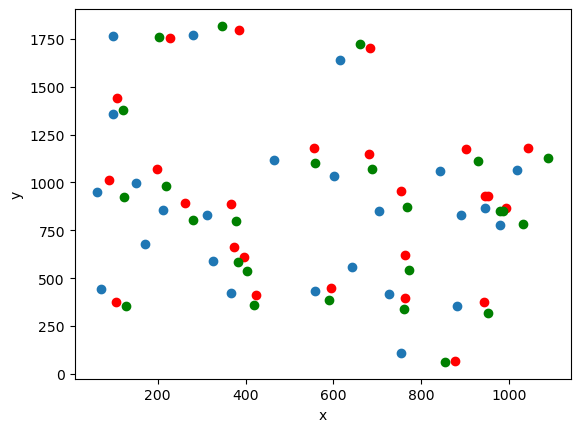

In [15]:
# C) ---------------------------------
# Here I plot the true values as blue, the linear as red, and the quadratic as green.
# (for set 0)
predictedXsLinear, predictedYsLinear = calculatePredictions(0, 1)
predictedXsQuadratic, predictedYsQuadratic = calculatePredictions(0, 2)

plt.scatter(positions_test[0].x, positions_test[0].y)

plt.scatter(predictedXsLinear, predictedYsLinear, color='r')
plt.scatter(predictedXsQuadratic, predictedYsQuadratic, color='g')
plt.xlabel('x')
plt.ylabel('y')

# Overall it can be seen that the quadratic model (green dots) are generally closer to the true coordinates.
# In the calculated mean values, it can also be seen that these are lower for the quadratic model, meaning that the errors are overall smaller.
# For the calculated variance values, these are higher for the quadratic model, meaning this is making more adjustments depending on the data
# (which I assume makes good sense, as the quadratic model is more flexible than the linear one)

# In terms of which model is best in certain situations, it will depend on what sort of order the data follows.
# With this, I mean that if the data clearly follows a linear model, a linear model will be best in that situation.
# However, if it is closer to following a higher order model, then a linear model would underfit.
# In this particular case, since the results are generally better with the quadratic model,
# the linear model is quite likely underfitting, while the quadratic model would be closer to a better fit.
# The limited amount of training data in each set might also be affecting how good of a fit can be achieved with both of the models.
